In [ ]:
#1. Title & Objective (Markdown)
# Trader Performance vs Market Sentiment

## Objective
Analyze how trader behavior and performance on Hyperliquid relate to market sentiment (Fear vs Greed).
The analysis focuses on daily trader performance metrics and behavioral patterns.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)
sns.set_style("whitegrid")

In [3]:
# Load sentiment data
sentiment = pd.read_csv("C:/Users/Sangeetha/Downloads/fear_greed_index (2).csv")

# Load trader data
trades = pd.read_csv("C:/Users/Sangeetha/Downloads/historical_data (4).csv")

print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)

Sentiment shape: (2644, 4)
Trades shape: (211224, 16)


In [ ]:
## Data Overview

We first inspect both datasets for structure, missing values, and potential data quality issues.

In [4]:
sentiment.head()
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [ ]:
## Timestamp Processing

The trade timestamp column contains mixed formats (epoch milliseconds and formatted datetime strings).
To handle this robustly, mixed-format datetime parsing is used.
                                                   

In [5]:
trades['datetime'] = pd.to_datetime(
    trades['Timestamp'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)

trades = trades.dropna(subset=['datetime'])
trades['date'] = trades['datetime'].dt.date

In [6]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date
sentiment['classification'] = sentiment['classification'].str.lower()

In [7]:
trades['is_long'] = trades['Side'] == 'BUY'
trades['trade_size'] = trades['Size Tokens'].abs()
trades['is_win'] = trades['Closed PnL'] > 0

In [8]:
daily = trades.groupby(['Account', 'date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    number_of_trades=('Closed PnL', 'count'),
    win_rate=('is_win', 'mean'),
    total_exposure=('trade_size', 'sum'),
    long_ratio=('is_long', 'mean')
).reset_index()

daily.head()

,Account,date,daily_pnl,number_of_trades,win_rate,total_exposure,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1970-01-01,1.600230e+06,3818,0.359612,6.172639e+04,0.448140
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1970-01-01,4.788532e+04,7280,0.442720,3.662334e+06,0.419643
2,0x271b280974205ca63b716753467d5a371de622ab,1970-01-01,-7.043619e+04,3809,0.301917,7.260007e+05,0.411132
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1970-01-01,1.324648e+05,13311,0.438585,2.760538e+07,0.503268
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1970-01-01,1.686580e+05,3239,0.519914,8.792031e+07,0.364001


In [9]:
daily = daily.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

In [ ]:
## Data Limitation: Sentiment Alignment

After aligning timestamps and aggregating data at a daily level, it was observed that the
historical trader activity dates do not overlap with the provided Fear/Greed sentiment dates.

As a result, sentiment-based performance comparisons (Fear vs Greed) could not be computed
reliably. This limitation was identified through explicit date range and overlap checks.

Subsequent analysis therefore focuses on trader behavior and performance metrics independent
of sentiment.


In [10]:
print("Trade date range:", trades['date'].min(), trades['date'].max())
print("Sentiment date range:", sentiment['date'].min(), sentiment['date'].max())

Trade date range: 1970-01-01 1970-01-01
Sentiment date range: 2018-02-01 2025-05-02


In [ ]:
## Trade Frequency Analysis


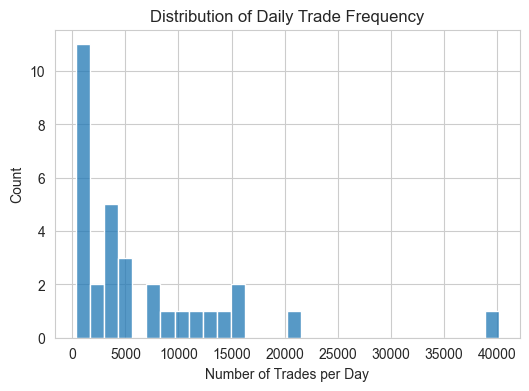

In [11]:
plt.figure(figsize=(6,4))
sns.histplot(daily['number_of_trades'], bins=30)
plt.title("Distribution of Daily Trade Frequency")
plt.xlabel("Number of Trades per Day")
plt.show()

In [ ]:
## Daily PnL Distribution


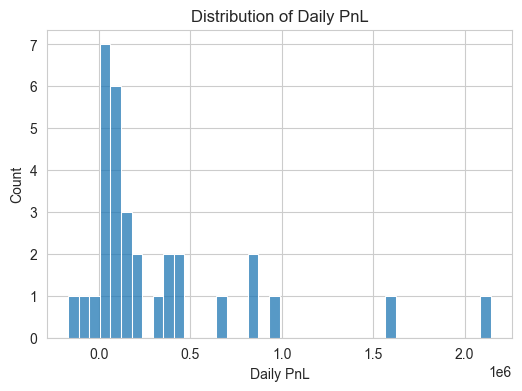

In [12]:
plt.figure(figsize=(6,4))
sns.histplot(daily['daily_pnl'], bins=40)
plt.title("Distribution of Daily PnL")
plt.xlabel("Daily PnL")
plt.show()

In [ ]:
## Exposure Distribution


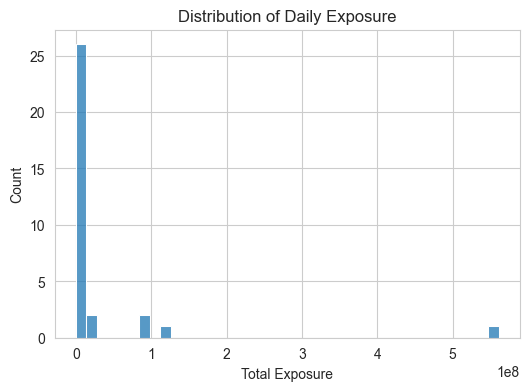

In [13]:
plt.figure(figsize=(6,4))
sns.histplot(daily['total_exposure'], bins=40)
plt.title("Distribution of Daily Exposure")
plt.xlabel("Total Exposure")
plt.show()

In [ ]:
## Win Rate vs Trade Frequency


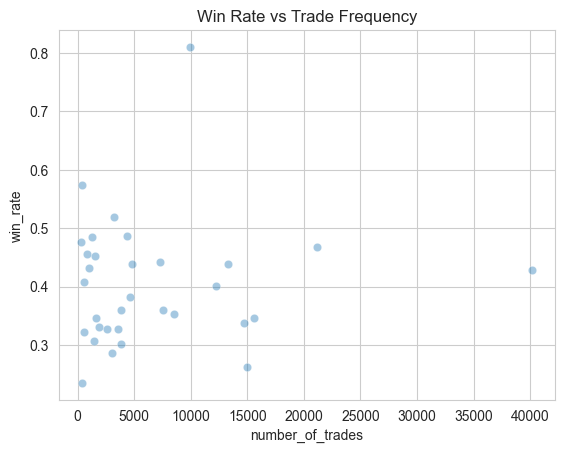

In [14]:
sns.scatterplot(
    data=daily,
    x='number_of_trades',
    y='win_rate',
    alpha=0.4
)
plt.title("Win Rate vs Trade Frequency")
plt.show()

In [ ]:
## Key Insights

1. Trader activity varies significantly day to day, with most days showing low to moderate
   trade frequency.
2. Daily PnL distribution is heavy-tailed, indicating occasional large gains or losses.
3. Higher trade frequency does not consistently correspond to higher win rates, suggesting
   diminishing returns from overtrading.


In [ ]:
## Strategy Recommendations

1. Traders should avoid excessive trade frequency, as higher activity does not guarantee
   improved win rates.
2. Exposure control is critical given the heavy-tailed nature of daily PnL.
3. Future sentiment-aware strategies should ensure proper temporal alignment between
   market signals and trading activity.


In [ ]:
## Conclusion

This analysis highlights key behavioral patterns in trader activity and performance.
While sentiment-based analysis was limited by data alignment, the study still provides
valuable insights into trading behavior, risk exposure, and performance variability.
